In [71]:
import tqdm
from iqoptionapi.stable_api import IQ_Option
import json 
import statistics
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections as cll

connector =IQ_Option("ww.bingonemo@gmail.com","JF*#3C5va&_NDqy")
connector.connect()

(True, None)

In [32]:
seconds_in_month = 2_592_000 
seconds_in_year = 31_536_000
max_dict = 1000
iqcomb = [("NZD", "SEK"),("NZD", "USD"),("CAD", "TRY"),("EUR", "CHF"),("USD", "THB"),("EUR", "TRY"),("GBP", "AUD"),("AUD", "USD"),("EUR", "MXN"),("USD", "CHF"),("NOK", "DKK"),("EUR", "NOK"),("SEK", "JPY"),("CAD", "NOK"),("NOK", "SEK"),("GBP", "HUF"),("GBP", "SGD"),("AUD", "NZD"),("GBP", "JPY"),("CHF", "SEK"),("AUD", "NOK"),("GBP", "NOK"),("AUD", "DKK"),("EUR", "AUD"),("AUD", "CHF"),("GBP", "CHF"),("AUD", "CAD"),("CHF", "DKK"),("AUD", "TRY"),("NZD", "CHF"),("USD", "SEK"),("GBP", "NZD"),("EUR", "DKK"),("NZD", "DKK"),("CAD", "SGD"),("EUR", "GBP"),("EUR", "CAD"),("USD", "CZK"),("AUD", "MXN"),("EUR", "NZD"),("GBP", "PLN"),("NZD", "NOK"),("AUD", "SGD"),("GBP", "SEK"),("NZD", "CAD"),("NZD", "MXN"),("NZD", "TRY"),("CHF", "SGD"),("USD", "MXN"),("EUR", "HUF"),("GBP", "CAD"),("USD", "TRY"),("USD", "JPY"),("EUR", "USD"),("AUD", "SEK"),("CHF", "NOK"),("USD", "PLN"),("USD", "HUF"),("CHF", "JPY"),("GBP", "ILS"),("NZD", "JPY"),("CHF", "TRY"),("CAD", "JPY"),("USD", "RUB"),("SGD", "JPY"),("GBP", "USD"),("CAD", "PLN"),("DKK", "SGD"),("NZD", "SGD"),("AUD", "JPY"),("NOK", "JPY"),("PLN", "SEK"),("USD", "SGD"),("GBP", "MXN"),("USD", "CAD"),("SEK", "DKK"),("DKK", "PLN"),("CAD", "MXN"),("GBP", "TRY"),("EUR", "SGD"),("NZD", "ZAR"),("EUR", "CZK"),("EUR", "JPY"),("CAD", "CHF"),("USD", "INR"),("USD", "BRL"),("USD", "NOK"),("USD", "DKK")]
candle_size = 3600 # 3600 is one hour
quantity = seconds_in_year / candle_size

In [33]:
end_from_time=time.time()
ANS=[]
for i in tqdm.tqdm(range(int(quantity/max_dict) + 1)):
    data=connector.get_candles("EURUSD", candle_size, max_dict, end_from_time)
    ANS =data+ANS
    end_from_time=int(data[0]["from"])-1
print(ANS[0], len(ANS))

100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

{'id': 16662, 'from': 1594036800, 'at': 1594040400005520500, 'to': 1594040400, 'open': 1.131875, 'close': 1.13294, 'min': 1.131525, 'max': 1.132985, 'volume': 10092} 9000


In [34]:
%store ANS

Stored 'ANS' (list)


In [35]:
ANSmean = statistics.mean([x['close'] for x in ANS])
ANSmean

1.1842801405555556

In [41]:
period = 72 * 3600

peakdiffset = []
timediffset = []
percset = []
idiffset = []

for i in ANS:
    if  ANS[-1]['from'] - i['from'] < period:
        continue
    period_candle_set = []
    for k in ANS:
        if k["from"] - i["from"] <= period and k["from"] - i["from"] > 0:
            period_candle_set.append(k)

    if len(period_candle_set) == 0:
        continue


    peakvalue = {'close': np.NINF}
    maxpeakvalue = {'max': np.NINF}

    for x in period_candle_set:
        if x['close'] > peakvalue['close']:
            peakvalue = x
        
        if x['max'] > maxpeakvalue['max']:
            maxpeakvalue = x

    peakdiff = peakvalue['close'] - i['close']
    maxpeakdiff = maxpeakvalue['close'] - i['max']
    timediff = peakvalue['from'] - i['from']
    maxtimediff = maxpeakvalue['from'] - i['from']

    perc = peakdiff/i['close']

    idiff = ANSmean - i['close']

    peakdiffset.append(peakdiff)
    timediffset.append(timediff)
    percset.append(perc)
    idiffset.append(idiff)

In [46]:
fset = [x for x in peakdiffset if x >= 0]
fpr = [x for x in percset if x >= 0]
ftm = [y for x, y in zip(peakdiffset, timediffset) if x>= 0 ]
fidf = [y for x, y in zip(peakdiffset, idiffset) if x>= 0 ] # mean deviation
print('Average increment: ',len(fset), statistics.mean(fset), statistics.stdev(fset))
print('Average percent: ', len(fpr), statistics.mean(fpr), statistics.stdev(fpr))
print('Average time:', len(ftm), statistics.mean(ftm), statistics.stdev(ftm))
print(len(fidf), format(statistics.mean(fidf), 'f'), statistics.stdev(fidf))

Average increment:  8238 0.004689226147123084 0.003986844688268269
Average percent:  8238 0.003968083587794108 0.0033904976510500803
Average time: 8238 118287.39985433358 86622.24643127421
8238 -0.000178 0.024447022605128595


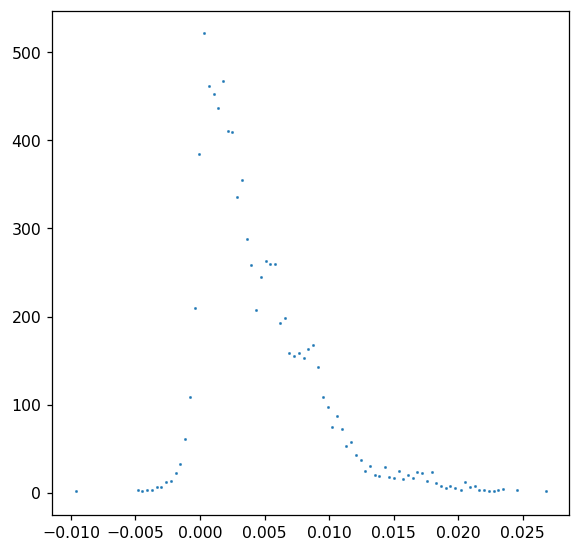

In [87]:
cm = 1/2.54  # centimeters in inches

fig, ax = plt.subplots(figsize=(15*cm, 15*cm), dpi=113)
div = 100
        
c = cll.Counter(pd.cut(peakdiffset, div))
ax.scatter([x.mid for x in c.keys()], c.values(), marker= ',' , s=0.40599)

